# Morphological-opening (rolling minimum) baseline

In [12]:
# Cell 1: imports
import pandas as pd
import numpy as np
from scipy.ndimage import grey_opening
from scipy.signal  import find_peaks


In [13]:
# Cell 2: prompt for inputs
input_xlsx   = input("Path to input Excel: ").strip()
phys_window  = float(input("Baseline window length (same units as distance): ").strip())
height_thr   = float(input("Min rib height above baseline: ").strip())
output_xlsx  = input("Path for output Excel: ").strip()


Path to input Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/Drumlin1_rib_profiles.xlsx
Baseline window length (same units as distance): 7
Min rib height above baseline: 0.1
Path for output Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/Drumlin1_rib_profiles_rollingwindow7.xlsx


In [14]:
# Cell 3: read sheets & init
sheets        = pd.read_excel(input_xlsx, sheet_name=None)
out_profiles  = {}
rib_summary   = []


In [15]:
# Cell 4: detrend + detect ribs
for name, df in sheets.items():
    if not {'distance','z'}.issubset(df.columns): 
        print(f"Skipping '{name}': missing cols"); continue

    d = df['distance']; spacing = d.diff().median()
    win_pts = int(phys_window/spacing) // 2 * 2 + 1
    
    z        = df['z'].values
    baseline = grey_opening(z, size=win_pts)
    zdt      = z - baseline

    peaks, _ = find_peaks(zdt, height=height_thr)
    df['baseline']    = baseline
    df['z_detrended'] = zdt
    df['is_rib']      = False
    df.loc[peaks, 'is_rib'] = True

    rib_summary += [
        {'profile': name,
         'distance': d.iat[i],
         'rib_height': zdt[i]}
        for i in peaks
    ]
    out_profiles[name] = df


Skipping '1-03c': missing cols
Skipping '1-16b': missing cols
Skipping '1-16e': missing cols
Skipping '1-16g': missing cols
Skipping '1-16l': missing cols
Skipping '1-16m': missing cols
Skipping '1-17': missing cols
Skipping '1-20': missing cols
Skipping '1-23': missing cols
Skipping '1-25a': missing cols
Skipping '1-54': missing cols


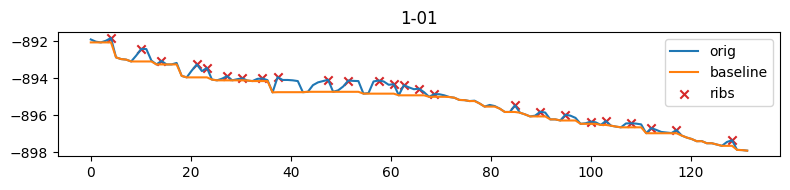

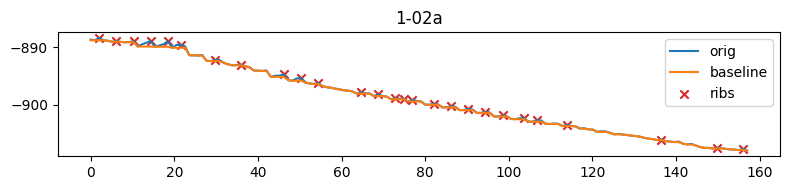

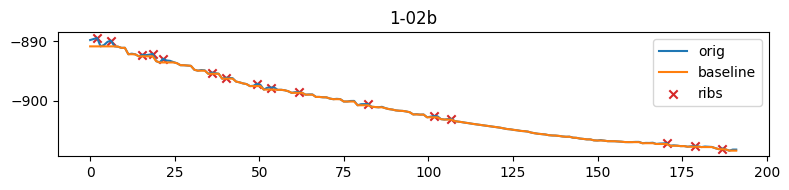

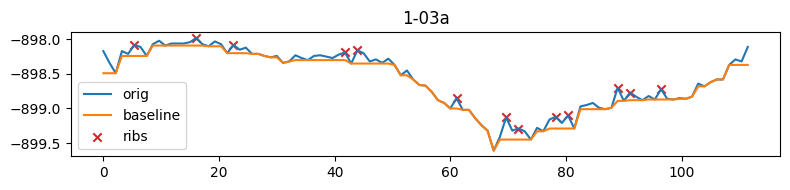

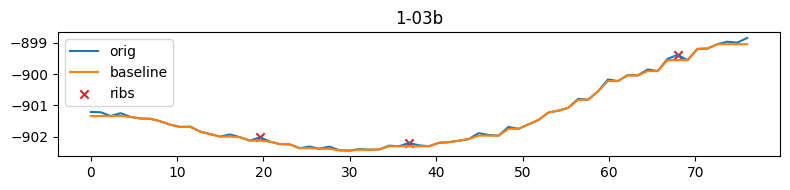

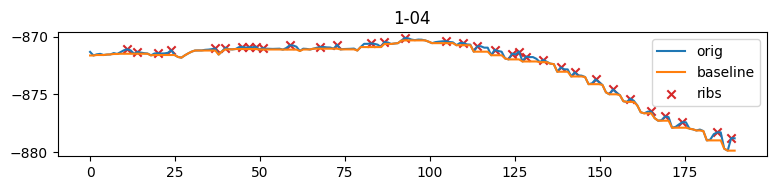

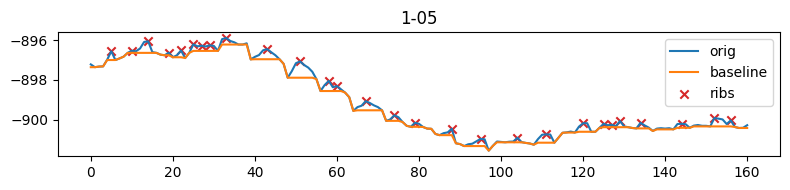

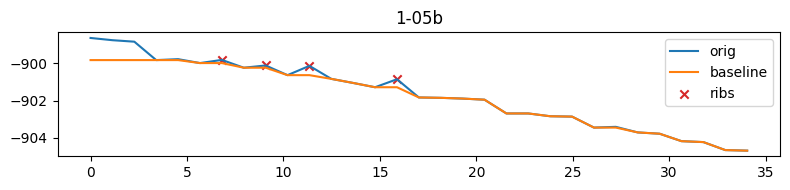

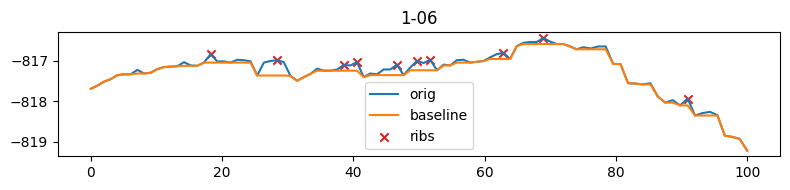

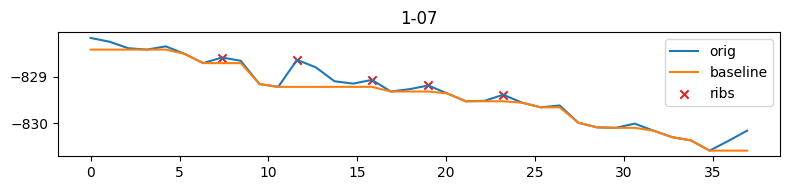

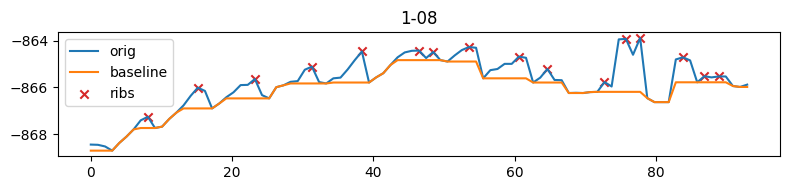

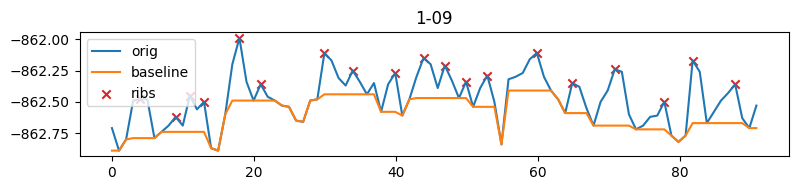

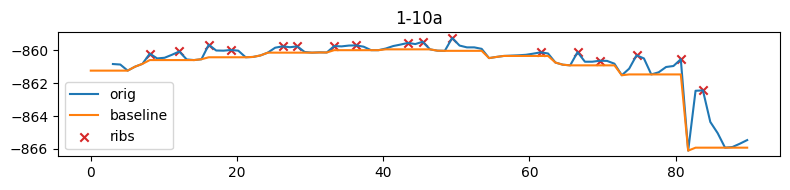

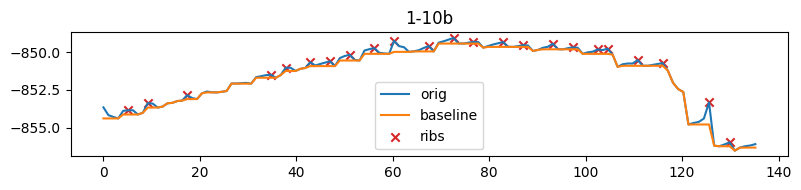

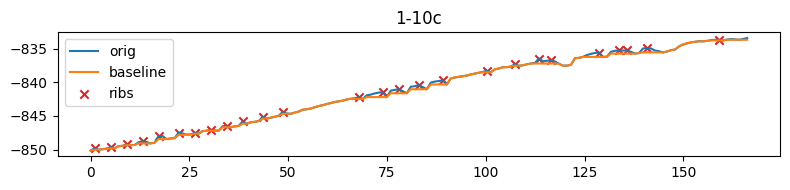

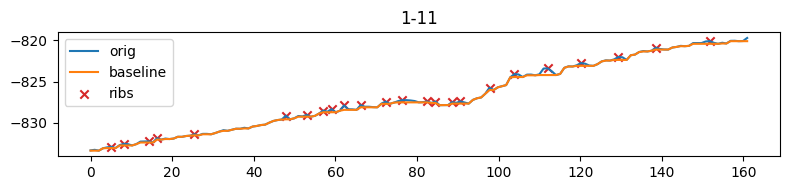

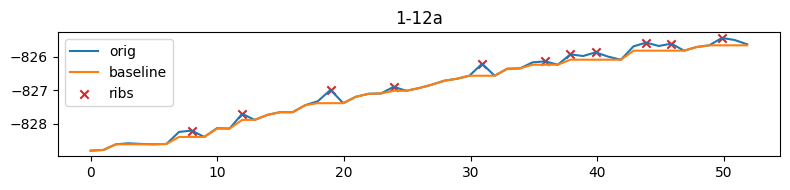

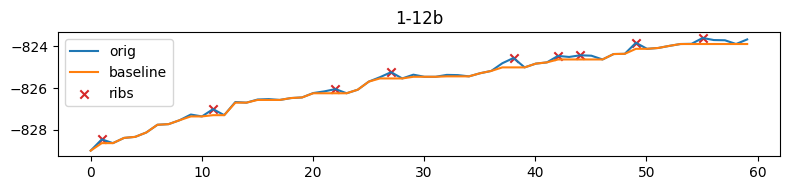

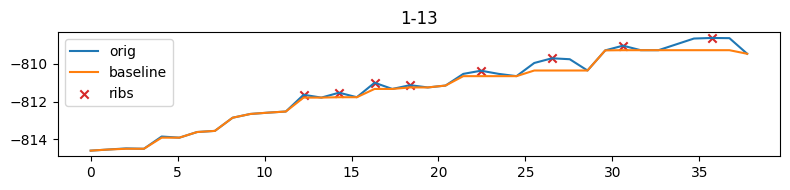

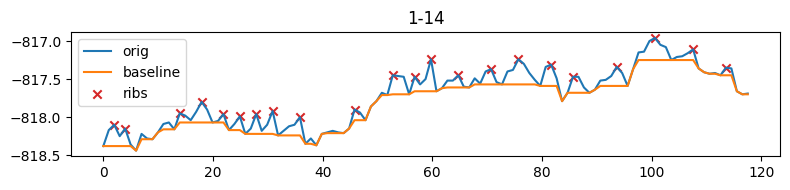

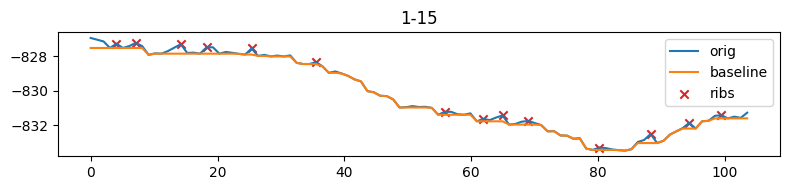

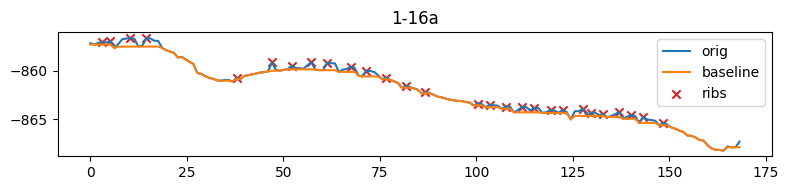

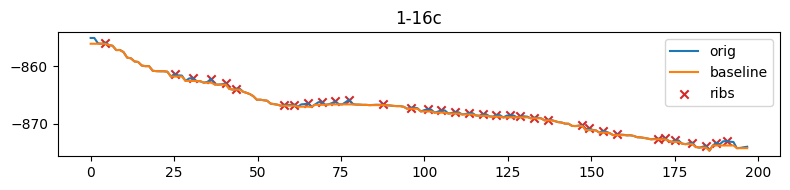

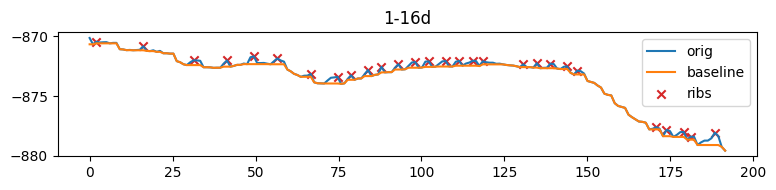

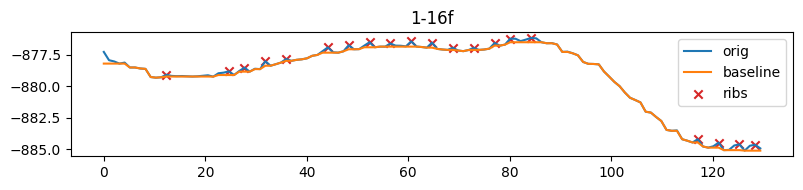

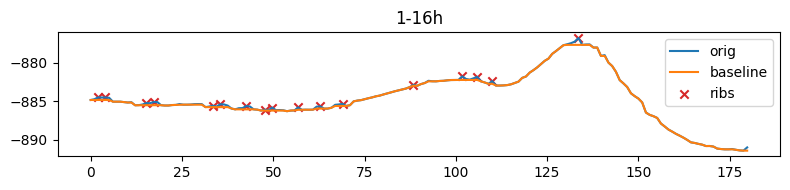

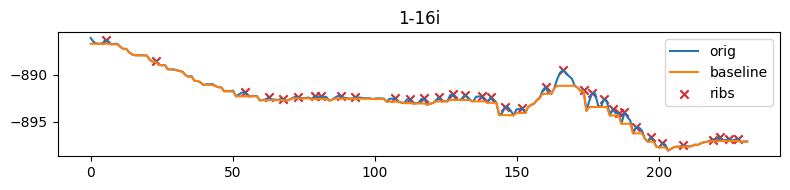

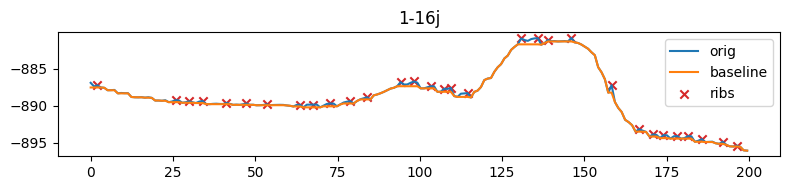

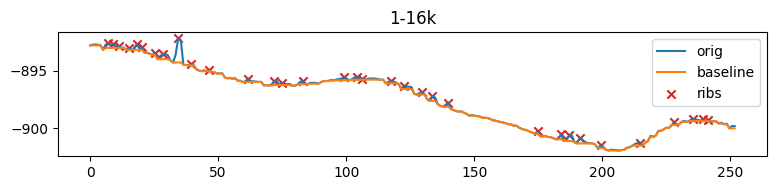

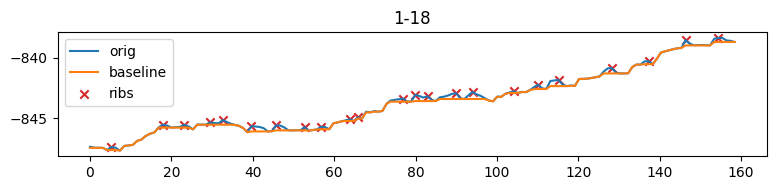

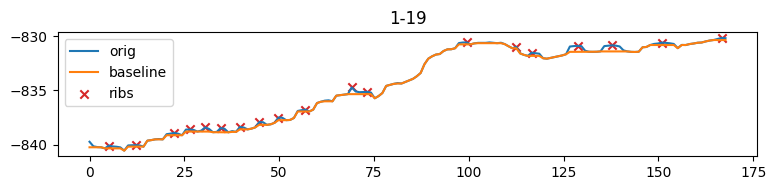

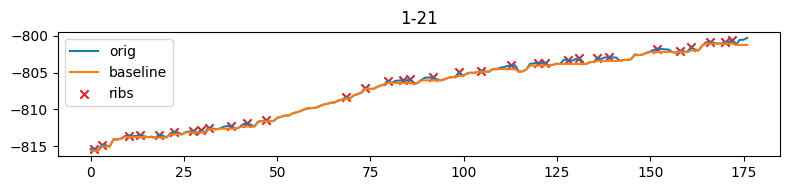

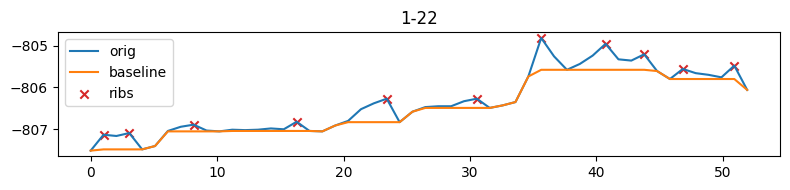

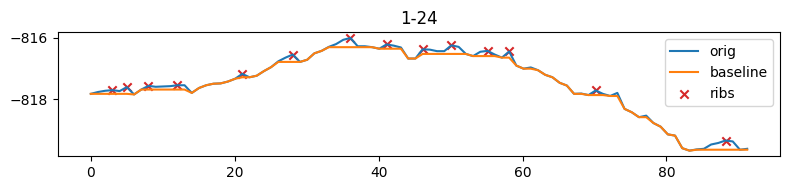

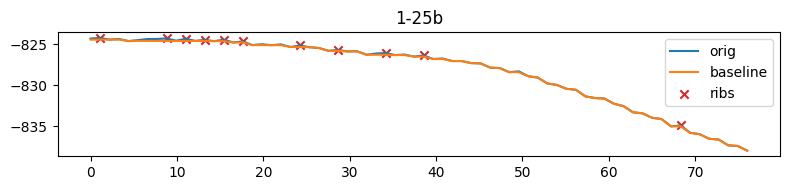

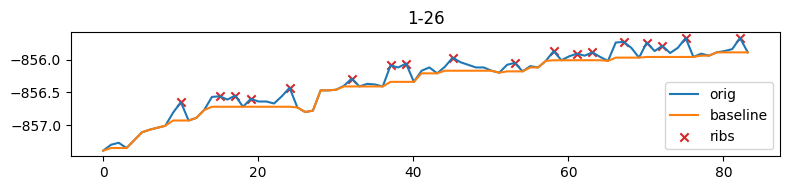

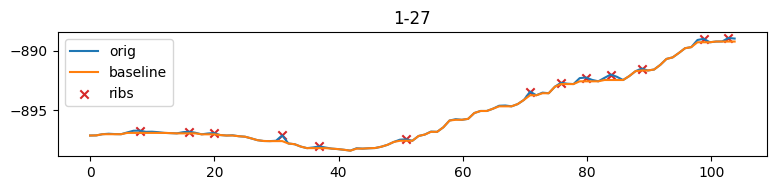

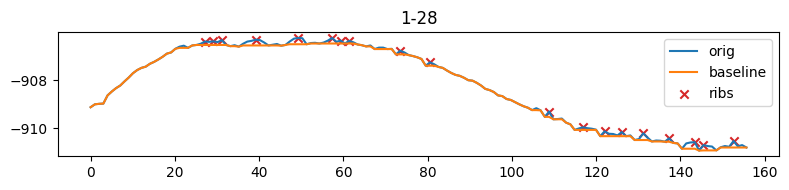

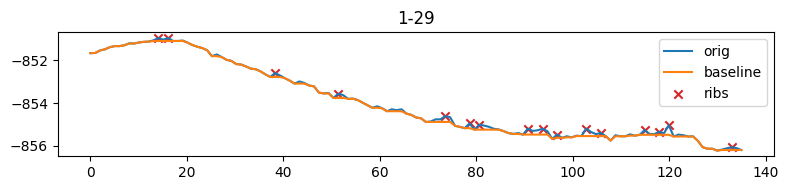

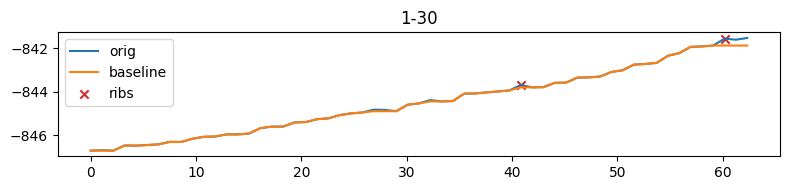

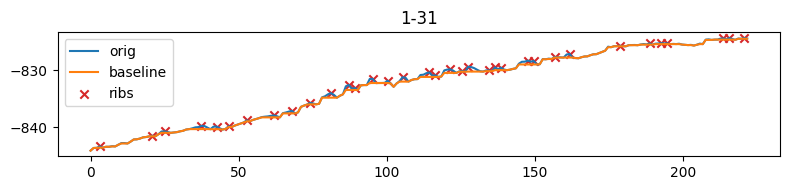

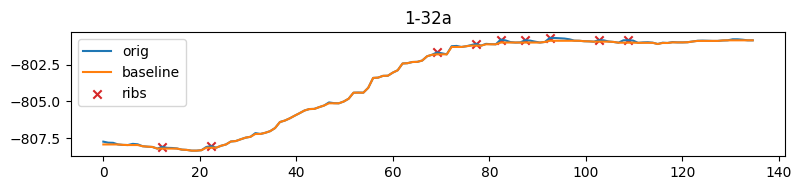

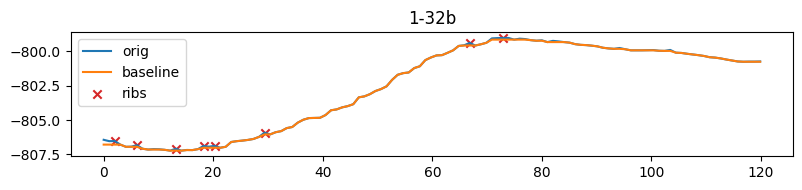

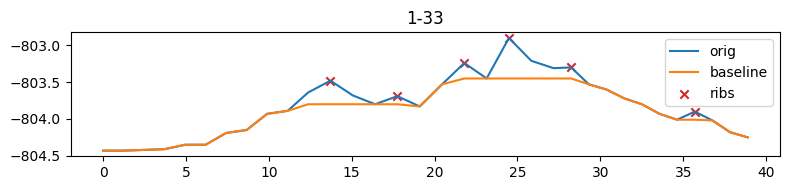

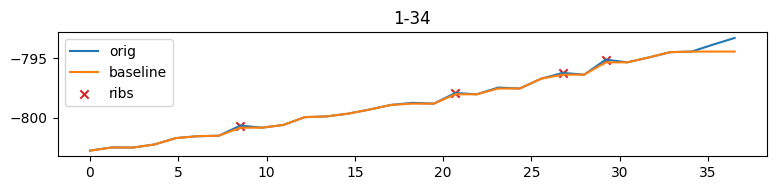

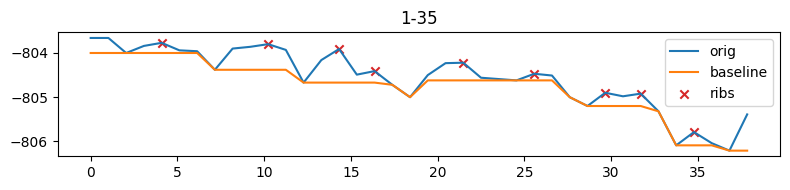

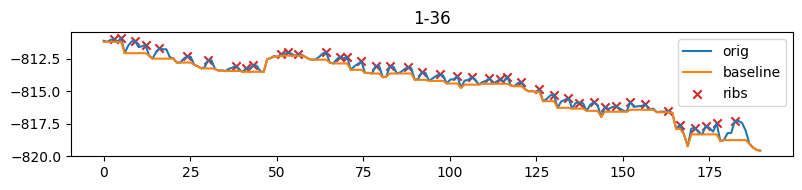

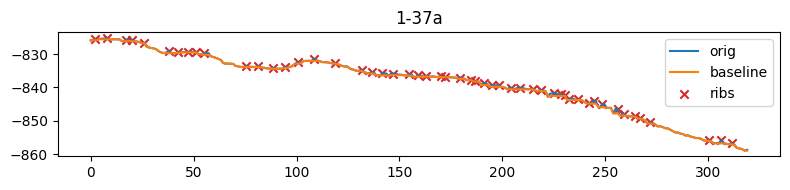

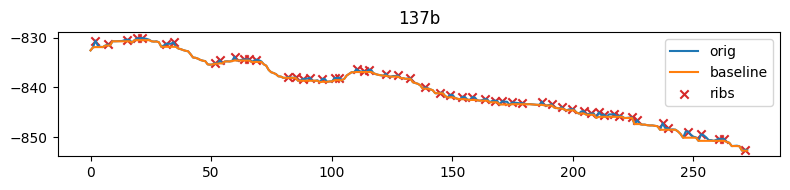

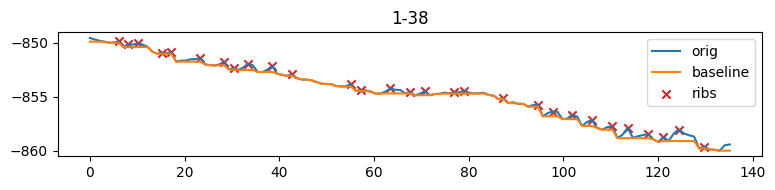

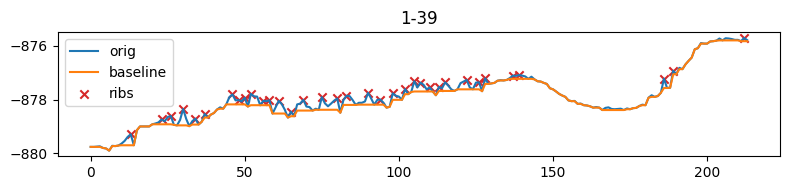

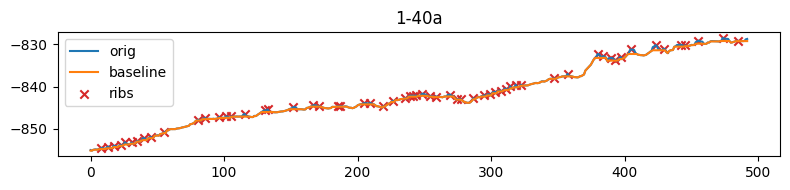

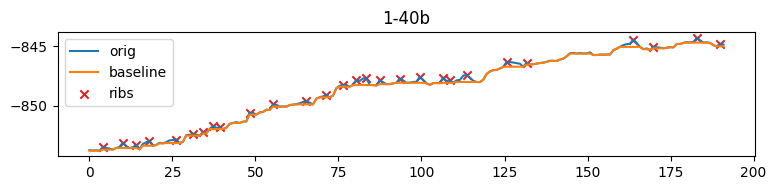

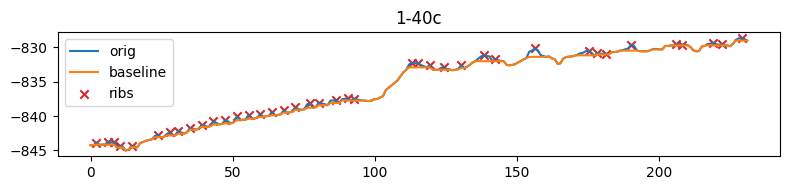

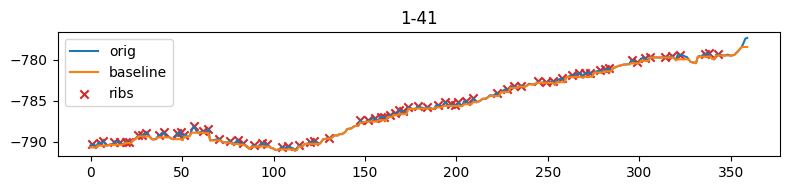

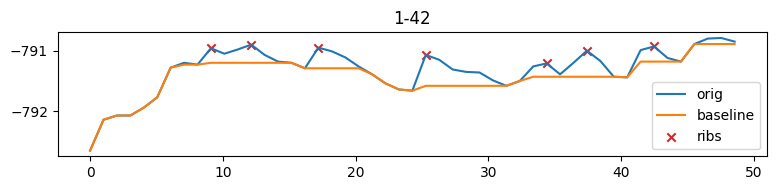

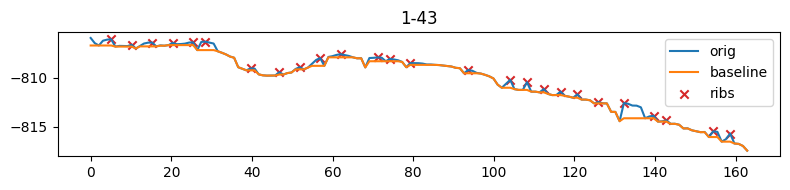

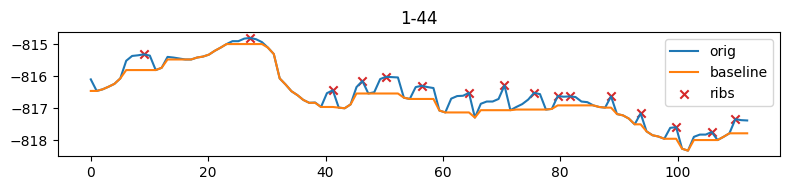

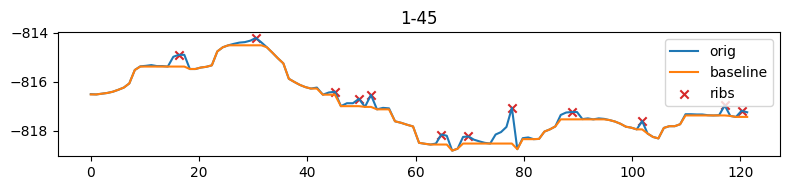

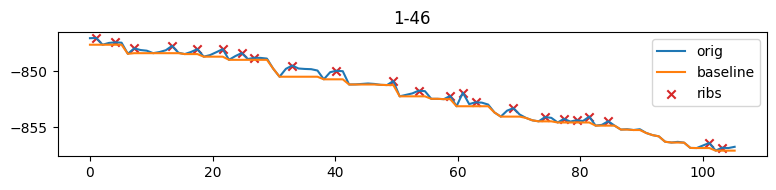

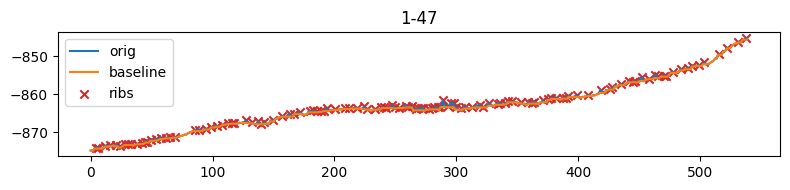

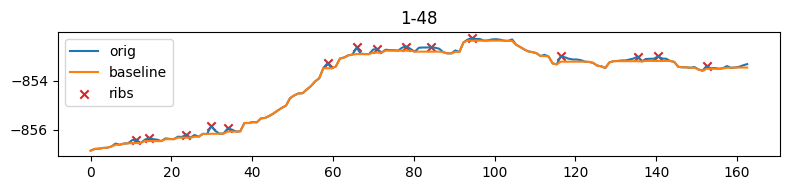

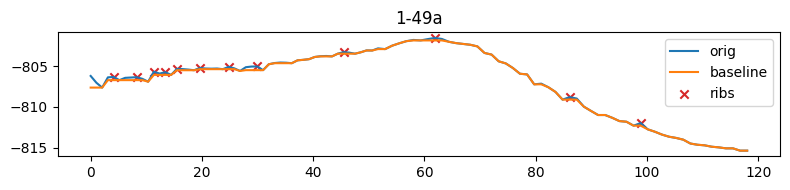

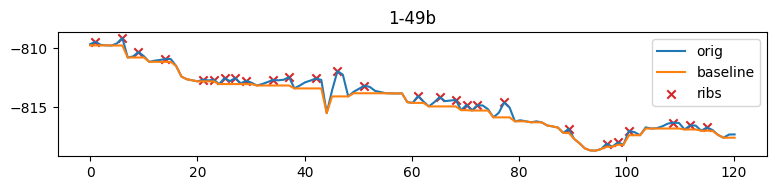

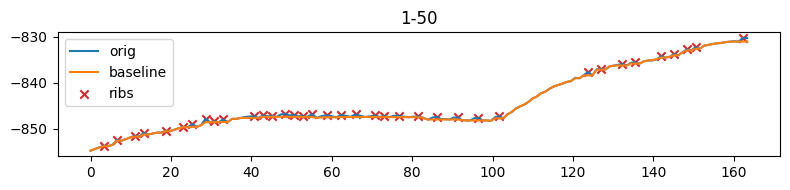

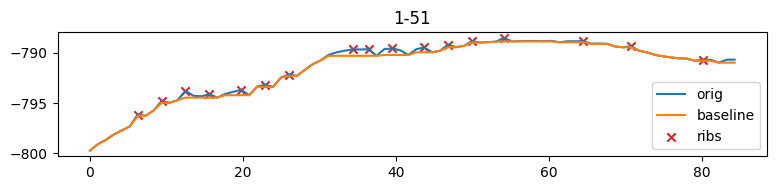

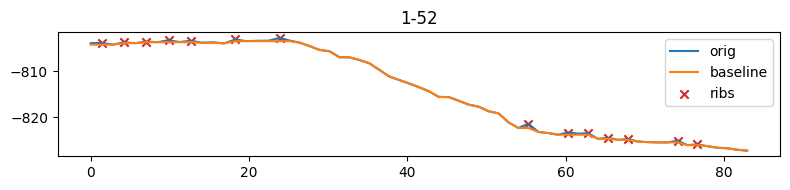

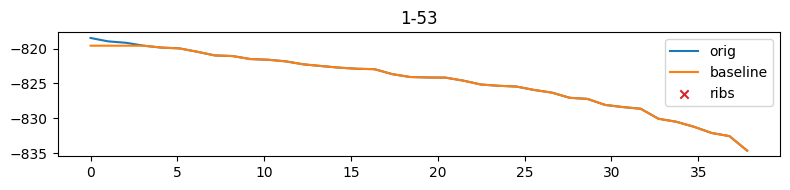

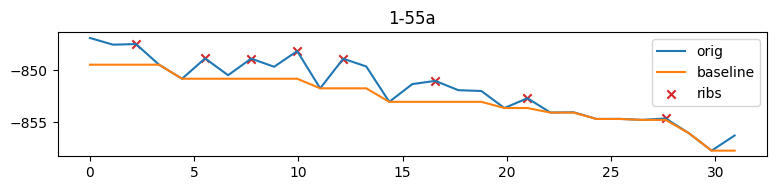

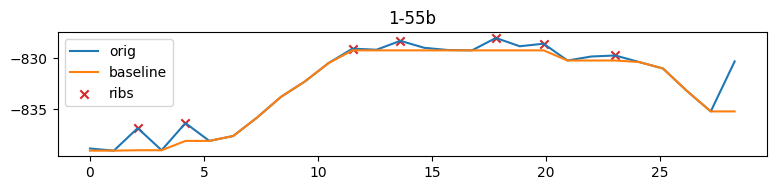

In [16]:
# Cell 5: quick plots for each profile
import matplotlib.pyplot as plt

for name, df in out_profiles.items():
    s = df['distance'].values
    z = df['z'].values
    baseline = df['baseline'].values
    zdt = df['z_detrended'].values
    peaks = np.flatnonzero(df['is_rib'])

    plt.figure(figsize=(8,2))
    plt.plot(s, z,      label='orig')
    plt.plot(s, baseline, label='baseline')
    plt.scatter(s[peaks], zdt[peaks] + baseline[peaks], marker='x', color='C3', label='ribs')
    plt.title(name); plt.legend(); plt.tight_layout()
    plt.show()


In [ ]:
# Cell 7: write results
with pd.ExcelWriter(output_xlsx, engine='openpyxl') as w:
    for name, df in out_profiles.items():
        df.to_excel(w, sheet_name=name, index=False)
    pd.DataFrame(rib_summary).to_excel(w, sheet_name='rib_summary', index=False)

print("✔ Done – results in", output_xlsx)


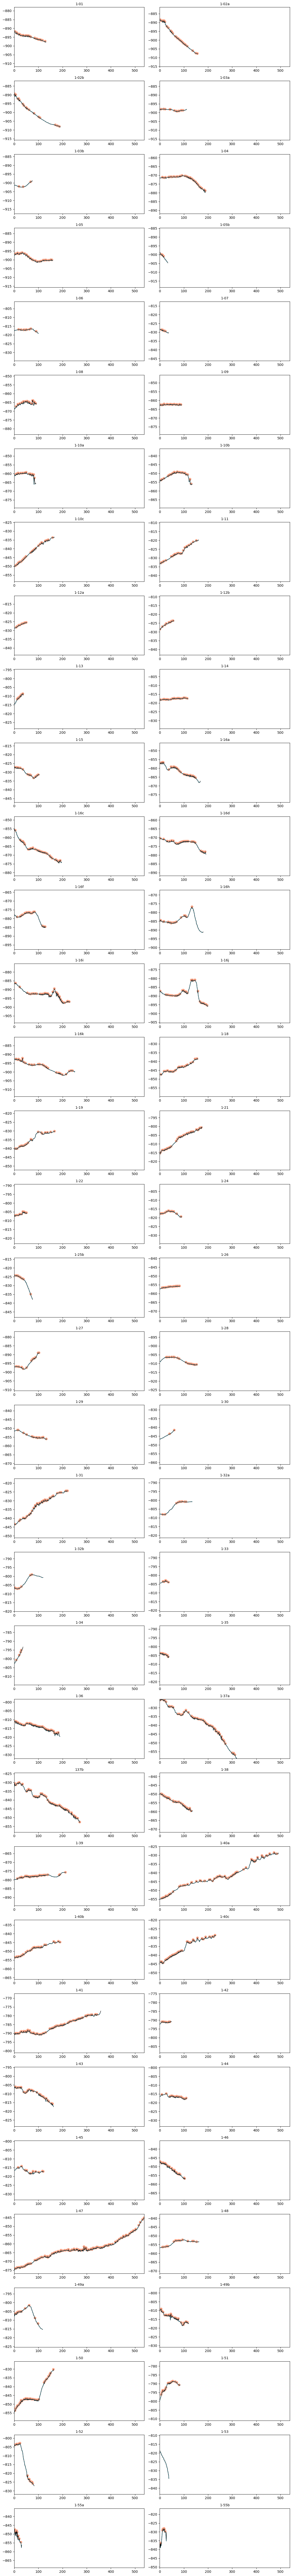

# Save plots

In [37]:
# Cell 1: imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmcrameri.cm as cmr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [38]:
# Cell 2: load workbook & normalize headers
fp = input("Enter Excel path: ")
all_sheets = pd.read_excel(fp, sheet_name=None)
for name, df in all_sheets.items():
    df.columns = df.columns.str.strip().str.lower()
    all_sheets[name] = df

Enter Excel path: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/Drumlin1_rib_profiles_rollingwindow7.xlsx


In [45]:
# Cell 3: pick sheets
avail = list(all_sheets.keys())
sel = input(f"Sheets ({', '.join(avail)} or 'all'): ")
chosen = avail if sel.lower().strip()=='all' else [s.strip() for s in sel.split(',')]
if not chosen:
    raise ValueError("No sheets selected!")


Sheets (1-01, 1-02a, 1-02b, 1-03a, 1-03b, 1-04, 1-05, 1-05b, 1-06, 1-07, 1-08, 1-09, 1-10a, 1-10b, 1-10c, 1-11, 1-12a, 1-12b, 1-13, 1-14, 1-15, 1-16a, 1-16c, 1-16d, 1-16f, 1-16h, 1-16i, 1-16j, 1-16k, 1-18, 1-19, 1-21, 1-22, 1-24, 1-25b, 1-26, 1-27, 1-28, 1-29, 1-30, 1-31, 1-32a, 1-32b, 1-33, 1-34, 1-35, 1-36, 1-37a, 137b, 1-38, 1-39, 1-40a, 1-40b, 1-40c, 1-41, 1-42, 1-43, 1-44, 1-45, 1-46, 1-47, 1-48, 1-49a, 1-49b, 1-50, 1-51, 1-52, 1-53, 1-55a, 1-55b, rib_summary or 'all'): 1-47


In [46]:
# Cell 4: filter & sort
def numkey(s):
    m = re.match(r"(\d+)", s)
    return int(m.group(1)) if m else float('inf')

clean = {}
required = {'distance','z','baseline','z_detrended','is_rib'}
for name in sorted(chosen, key=numkey):
    df = all_sheets.get(name)
    if df is None or not required.issubset(df.columns):
        print(f"Skipping '{name}' (missing cols)")
        continue
    mask = np.isfinite(df['z'])
    if mask.sum()==0:
        print(f"Skipping '{name}' (no finite z)")
        continue
    clean[name] = df.loc[mask].copy()

if not clean:
    raise ValueError("No valid sheets remain.")

In [58]:
# Cell 5: compute global spans (as before)
z_ranges  = [(df['z'].max() - df['z'].min()) for df in clean.values()]
max_range = max(z_ranges)
all_s     = np.hstack([df['distance'].values for df in clean.values()])
x_min, x_max = np.nanmin(all_s), np.nanmax(all_s)
cmap = cmr.batlow; base_col, rib_col = cmap(0.2), cmap(0.8)

In [64]:
# Cell 6: vertical exaggeration → scale axis length instead of y‐range
ve = input("Enter vertical exaggeration (1 = normal height, 2 = double height, etc.): ")
try:
    ve = float(ve)
except ValueError:
    print("Invalid entry; defaulting to 1.0")
    ve = 1.0

# base height per subplot (in inches)
base_h = 2  
# compute total figure height
fig_height = len(clean) * base_h * ve

print(f" → Figure height = {fig_height:.1f}\" ({ve}× base {base_h}\" per plot)")

Enter vertical exaggeration (1 = normal height, 2 = double height, etc.): 4
 → Figure height = 8.0" (4.0× base 2" per plot)


Enter output PNG filename: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/1-47rollingwindow7_4x.png
Saved to /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/1-47rollingwindow7_4x.png


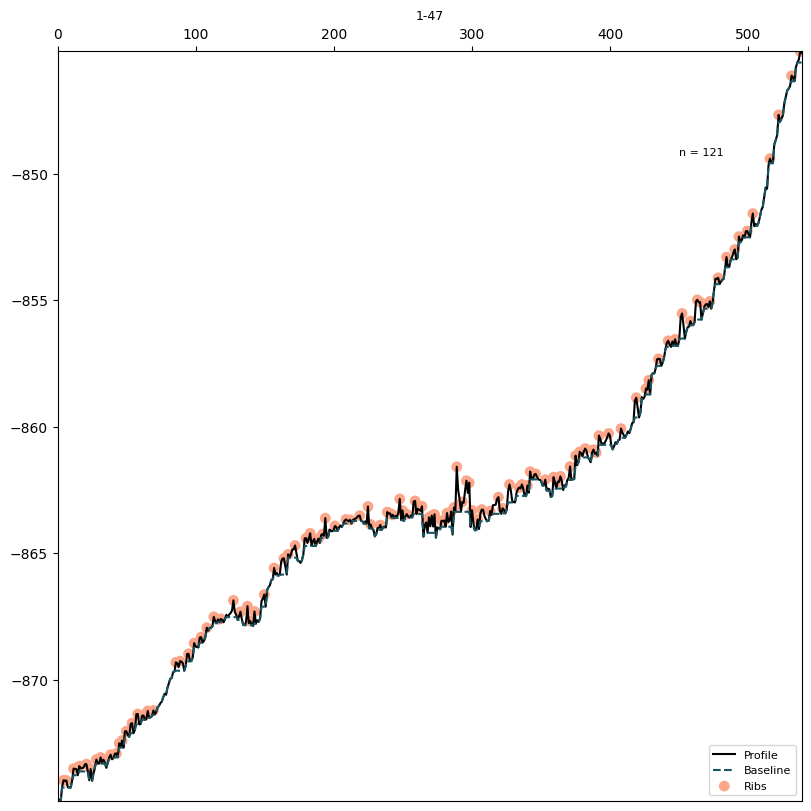

In [65]:
# Cell 7: stacked plots with VE‑scaled height & save
fig, axes = plt.subplots(
    len(clean), 1,
    figsize=(8, fig_height),
    sharex=True,
    constrained_layout=True
)
if len(clean) == 1:
    axes = [axes]

for i, (name, df) in enumerate(clean.items()):
    ax = axes[i]
    s, z        = df['distance'].values, df['z'].values
    base, zdt   = df['baseline'].values, df['z_detrended'].values
    peaks       = np.flatnonzero(df['is_rib'])

    # plot profile, baseline, ribs
    ax.plot(s, z,    color='black', label='Profile')
    ax.plot(s, base, '--',        color=base_col, label='Baseline')
    ax.scatter(
        s[peaks], base[peaks]+zdt[peaks],
        s=60, marker='o', facecolor=rib_col,
        edgecolor='none', label='Ribs'
    )

    # inset with rib count
    ax_i = inset_axes(ax, width="25%", height="25%", loc='upper right')
    ax_i.axis('off')
    ax_i.text(0.5, 0.5, f"n = {int(df['is_rib'].sum())}",
              ha='center', va='center', fontsize=8)

    # uniform y‑limits (no VE on data range)
    mid = (z.max() + z.min()) / 2
    ax.set_ylim(mid - max_range/2, mid + max_range/2)
    ax.set_xlim(x_min, x_max)
    ax.set_title(name, fontsize=9)

    # x‑axis only on top & bottom
    if i == 0:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    elif i < len(clean) - 1:
        ax.tick_params(labelbottom=False, labeltop=False)

    ax.legend(loc='lower right', fontsize=8)

# save to PNG
out_png = input("Enter output PNG filename: ")
fig.savefig(out_png, dpi=300)
print(f"Saved to {out_png}")
plt.show()


# Get rib details

In [19]:
# Cell 1: imports
import pandas as pd
import numpy as np


In [20]:
# Cell 2: prompt for input/output
input_xlsx  = input("Path to input Excel: ").strip()
output_xlsx = input("Path for output Excel: ").strip()


Path to input Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/Drumlin1_rib_profiles_rollingwindow7.xlsx
Path for output Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/Drumlin1_rib_profiles_rollingwindow7_details.xlsx


In [21]:
# Cell 3: read all sheets & init
sheets          = pd.read_excel(input_xlsx, sheet_name=None)
summary_sheets  = {}



In [22]:
# Cell 4: build per‑sheet summaries
for name, df in sheets.items():
    if 'is_rib' not in df.columns: 
        continue
    ribs = df[df['is_rib']].sort_values('distance').reset_index(drop=True)
    if ribs.empty:
        continue
    ribs = ribs.assign(
        rib_number = ribs.index + 1,
        spacing    = ribs['distance'].shift(-1) - ribs['distance'],
        height     = ribs['z_detrended']
    )
    summary_sheets[name] = ribs[[
        'rib_number','lat','long','z','spacing','height'
    ]].rename(columns={
        'lat':'latitude',
        'long':'longitude',
        'z':'water_depth'
    })


In [23]:
# Cell 5: write out only summary sheets
with pd.ExcelWriter(output_xlsx, engine='openpyxl') as w:
    for name, df_sum in summary_sheets.items():
        df_sum.to_excel(w, sheet_name=name, index=False)
print("✔ Done – per‑sheet summaries written to", output_xlsx)


✔ Done – per‑sheet summaries written to /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/Drumlin1_rib_profiles_rollingwindow7_details.xlsx


# Summary Statistics

In [24]:
# Cell 1: imports
import pandas as pd


In [26]:
# Cell 2: prompt for input/output
input_xlsx  = input("Path to rib_summary Excel: ").strip()
output_xlsx = input("Path for summary stats Excel: ").strip()


Path to rib_summary Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/Drumlin1_rib_profiles_rollingwindow7_details.xlsx
Path for summary stats Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/Drumlin1_rib_profiles_rollingwindow7_stats.xlsx


In [27]:
# Cell 3: read all rib_summary sheets
details = pd.read_excel(input_xlsx, sheet_name=None)


In [28]:
# Cell 4: compute per‑sheet statistics
summary_sheets = {}
for name, df in details.items():
    s = df['spacing'].dropna()
    h = df['height'].dropna()
    summary_sheets[name] = pd.DataFrame({
        'mean_spacing': [s.mean()],
        'std_spacing':  [s.std()],
        'min_spacing':  [s.min()],
        'max_spacing':  [s.max()],
        'mean_height':  [h.mean()],
        'std_height':   [h.std()],
        'min_height':   [h.min()],
        'max_height':   [h.max()]
    })


In [29]:
# Cell 5: compute overall dataset statistics
num_profiles = len(details)
ribs_counts  = [len(df) for df in details.values()]
avg_ribs     = sum(ribs_counts) / num_profiles
all_df       = pd.concat(details.values(), ignore_index=True)
s_all        = all_df['spacing'].dropna()
h_all        = all_df['height'].dropna()
overall = pd.DataFrame({
    'avg_ribs_per_profile': [avg_ribs],
    'mean_spacing':         [s_all.mean()],
    'std_spacing':          [s_all.std()],
    'min_spacing':          [s_all.min()],
    'max_spacing':          [s_all.max()],
    'mean_height':          [h_all.mean()],
    'std_height':           [h_all.std()],
    'min_height':           [h_all.min()],
    'max_height':           [h_all.max()]
})


In [30]:
# Cell 6: write all summaries to Excel
with pd.ExcelWriter(output_xlsx, engine='openpyxl') as writer:
    for name, df_sum in summary_sheets.items():
        df_sum.to_excel(writer, sheet_name=name, index=False)
    overall.to_excel(writer, sheet_name='overall_summary', index=False)
print("✔ Done – statistics written to", output_xlsx)


✔ Done – statistics written to /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin1 rib profiles/Drumlin1_rib_profiles_rollingwindow7_stats.xlsx
